## Rakeshwer's Master Thesis 2022: 

### "Time Series Prediction with ANNs on non-linear and non-stationary Time Series"

**Idea:**
In notebook 05 we failed on **technical features** as inputs for predicting SP500 close (rel.chg.). Now go beyond first steps and add external features to answer:

**Q2:** Do **external features** help improving accuracy? (mostly macroeconomic indices: GDP, inflation expectation, interest rates,...)

**Outline:**

- And look at **distribution and range for ALL features**: What's the necessary scaling? [0,1] or [-1,+1],...
- Try **simple CNN/fc model** with multi-dimensional input.

Stick to **input length 20d** and try various **target horizons (1d / 5d / 10d / 20d)** for **SP500 close (rel. chg.)**.

### Tech Preamble

In [1]:
import sys
import datetime
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed, Input, Dense, Conv1D, Conv2D, AveragePooling1D, MaxPooling1D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, GaussianNoise, LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad, Nadam, RMSprop, schedules
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.datasets as tfds
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

### Import data

In [2]:
# Define path to data folder:
path_to_data = "../data"

# Import data from csv file:
data = np.genfromtxt(join(path_to_data,'SP500_InputFeatures_Targets.csv'), delimiter=';', skip_header=1)

In [3]:
# Check dimensions:
print("data shape (samples, features): ", data.shape)
print("\nfirst row: \n", data[0])

print("\nfeatures [column number]:")
print("=========================")
print("[0] - year")
print("[1] - open (abs)")
print("[2] - high (abs)")
print("[3] - low (abs)")
print("[4] - close (abs)")
print("[5] - close (rel chg)")
print("[6] - vol (abs)") # number of traded shares
print("[7] - vol (rel chg)")
print("[8] - range (abs)") # high - low
print("[9] - range (rel)") # range (abs) / close (abs)
print("[10] - target 1d (rel chg)")
print("[11] - target 5d (rel chg)")
print("[12] - target 10d (rel chg)")
print("[13] - target 20d (rel chg)")
print("[14] - close (abs) moving average 20d")
print("[15] - close (abs) moving average 50d")
print("[16] - close (abs) moving average 100d")
print("[17] - close (abs) moving average 200d")
print("[18] - dist (rel) of close (abs) to moving average 20d")
print("[19] - dist (rel) of close (abs) to moving average 50d")
print("[20] - dist (rel) of close (abs) to moving average 100d")
print("[21] - dist (rel) of close (abs) to moving average 200d")
print("[22] - RSI with 14d lookback")
print("[23] - Bollinger dist (rel) of close (abs) to its moving average 20d - expressed in std devs")
print("[24] - Bollinger short signal")
print("[25] - Bollinger long signal")
print("[26] - Combined Bollinger short/long signal")
print("[27] - Consumer Confidence")
print("[28] - Inflation rate YoY")
print("[29] - Inflation rate MoM")
print("[30] - Inflation expectation (short term)")
print("[31] - Consumer Price Index (abs)")
print("[32] - Consumer Price Index (rel chg)")
print("[33] - Producer Prices change YoY")
print("[34] - GDP growth rate QoQ")
print("[35] - Unemployment rate (abs)")
print("[36] - Unemployment rate (rel chg)")
print("[37] - FED Funds rate (abs)")
print("[38] - FED Funds rate (change)")
print("[39] - M0 money supply (abs)")
print("[40] - M0 money supply (rel chg)")
print("[41] - 10y US Bond yield (abs)")
print("[42] - 10y US Bond yield (change)")
print("[43] - Oil price (abs)")
print("[44] - Oil price (rel chg)")
print("[45] - Business Confidence")
print("[46] - Philly FED Index")
print("[47] - Federal Debt relative to GDP")
print("[48] - Baltic Dry Index (abs)")
print("[49] - Baltic Dry Index (rel chg)")
print("[50] - Dist (rel) of volume (abs) to its moving average 20d - expressed in std devs")

data shape (samples, features):  (9406, 51)

first row: 
 [ 1.98500000e+03  1.63680000e+02  1.64710000e+02  1.63680000e+02
  1.64240000e+02  3.42131000e-03  8.61900000e+07  1.12416107e-01
  1.03000000e+00  6.27131000e-03 -1.52216300e-03  3.81758400e-02
  6.69142720e-02  9.80881640e-02  1.64820000e+02  1.65369600e+02
  1.65455200e+02  1.60508200e+02 -3.51899000e-03 -6.83076000e-03
 -7.34458600e-03  2.32499020e-02  5.77415074e-01 -3.02335523e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  9.29000000e+01
  3.90000000e-02  2.00000000e-03  3.30000000e-02  1.05300000e+02
  7.65550200e-03  1.66000000e-02  3.30000000e-02  7.30000000e-02
  1.38888890e-02  8.25000000e-02 -5.00000000e-03  2.04800000e+05
  2.09371880e-02  1.14700000e-01 -1.80000000e-03  2.55600000e+01
  1.50913420e-02  5.06000000e+01  2.10000000e+00  3.96000000e-01
  9.98000000e+02 -2.00000000e-03 -2.95289790e-02]

features [column number]:
[0] - year
[1] - open (abs)
[2] - high (abs)
[3] - low (abs)
[4] - close (abs)
[5] - 

In [4]:
# Extract year for seperating data into train / validation / test sets
year = data[:,0]

## Extract ALL technical plus external input features.
# [5] - close (rel chg)
# [7] - vol (rel chg)
# [9] - range (rel)
# [18] - dist (rel) of close (abs) to moving average 20d
# [19] - dist (rel) of close (abs) to moving average 50d
# [20] - dist (rel) of close (abs) to moving average 100d
# [21] - dist (rel) of close (abs) to moving average 200d
# [22] - RSI with 14d lookback
# [23] - Bollinger dist (rel) of close (abs) to its moving average 20d - expressed in std devs
# [27] - Consumer Confidence
# [28] - Inflation rate YoY
# [29] - Inflation rate MoM
# [30] - Inflation expectation (short term)
# [32] - Consumer Price Index (rel chg)
# [33] - Producer Prices change YoY
# [34] - GDP growth rate QoQ
# [36] - Unemployment rate (rel chg)
# [38] - FED Funds rate (change)
# [40] - M0 money supply (rel chg)
# [42] - 10y US Bond yield (change)
# [44] - Oil price (rel chg)
# [45] - Business Confidence
# [46] - Philly FED Index
# [47] - Federal Debt relative to GDP
# [49] - Baltic Dry Index (rel chg)
# [50] - Dist (rel) of volume (abs) to its moving average 20d - expressed in std devs

inputs = data[:,(5,7,9,18,19,20,21,22,23,27,28,29,30,32,33,34,36,38,40,42,44,45,46,47,49,50)]
inputs_text = [
    "close (rel. chg.)",
    "volume (rel. chg.)",
    "range (rel.)",
    "dist (rel) of close (abs) to mvg avg 20d",
    "dist (rel) of close (abs) to mvg avg 50d",
    "dist (rel) of close (abs) to mvg avg 100d",
    "dist (rel) of close (abs) to mvg avg 200d",
    "RSI with 14d lookback",
    "Bollinger dist (rel) in std devs",
    "Consumer Confidence",
    "Inflation rate YoY",
    "Inflation rate MoM",
    "Inflation expectation (short term)",
    "Consumer Price Index (rel chg)",
    "Producer Prices change YoY",
    "GDP growth rate QoQ",
    "Unemployment rate (rel chg)",
    "FED Funds rate (change)",
    "M0 money supply (rel chg)",
    "10y US Bond yield (change)",
    "Oil price (rel chg)",
    "Business Confidence",
    "Philly FED Index",
    "Federal Debt relative to GDP",
    "Baltic Dry Index (rel chg)",
    "volume dist (rel) to mvg avg 20d in std devs"
]

## Extract target values for 1d / 5d / 10d / 20d as rel chg:
# [10] - target 1d (rel chg)
# [11] - target 5d (rel chg)
# [12] - target 10d (rel chg)
# [13] - target 20d (rel chg)

targets = data[:,10:14]
targets_text = [
    "1d",
    "5d",
    "10d",
    "20d",
]

# Check dimensions:
print("year shape (samples): ", year.shape)
print("inputs shape (samples, input features): ", inputs.shape)
print("targets shape (samples, output features): ", targets.shape)

year shape (samples):  (9406,)
inputs shape (samples, input features):  (9406, 26)
targets shape (samples, output features):  (9406, 4)


### Check distribution of input features and scale

- Check mean and standard deviation for all features.
- Plot distribution for visual inspection.

**NOTE:** Usually we should scale inputs only according to statistics from **train data**, since we don't know statistics for validation and test data in advance. We could neglect that and *cheat* by scaling inputs according to statistics from **all data** - for simplicity. But we don't! ;-)

In [5]:
# Get mean and standard deviation of RAW input features:
np.array(
    [
    np.round(np.mean(inputs,axis=0),3),
    np.round(np.std(inputs,axis=0),3)
    ]
)


array([[ 0.0000e+00,  2.2000e-02,  1.2000e-02,  3.0000e-03,  9.0000e-03,
         1.8000e-02,  3.7000e-02,  5.5400e-01,  3.1800e-01,  8.7708e+01,
         2.7000e-02,  2.0000e-03,  3.0000e-02,  3.0000e-03,  2.2000e-02,
         2.6000e-02,  1.0000e-03, -2.0000e-03,  1.4000e-02, -0.0000e+00,
         0.0000e+00,  5.2472e+01,  8.6500e+00,  7.2100e-01,  0.0000e+00,
         2.3000e-02],
       [ 1.1000e-02,  3.4600e-01,  1.0000e-02,  2.5000e-02,  3.9000e-02,
         5.5000e-02,  7.8000e-02,  1.5500e-01,  1.2640e+00,  1.1637e+01,
         1.4000e-02,  3.0000e-03,  6.0000e-03,  5.0000e-03,  2.6000e-02,
         4.6000e-02,  1.6300e-01,  4.0000e-03,  4.8000e-02,  1.0000e-03,
         4.3000e-02,  4.9870e+00,  1.6009e+01,  2.2700e-01,  1.9000e-02,
         1.0550e+00]])

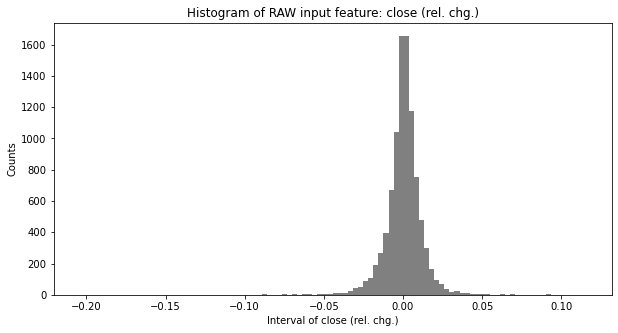

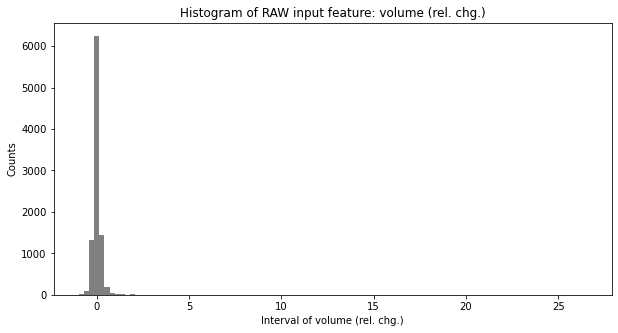

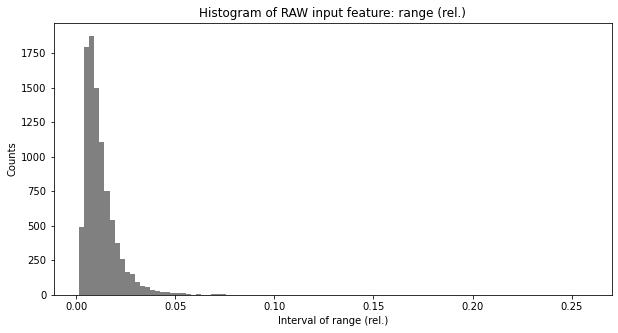

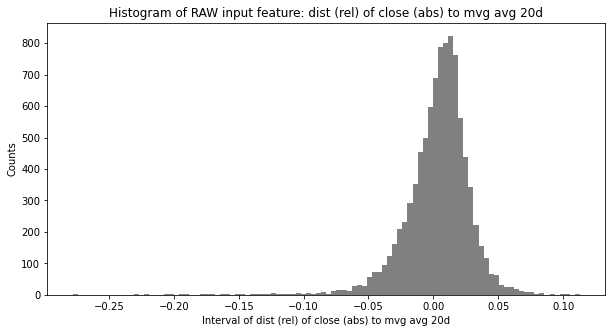

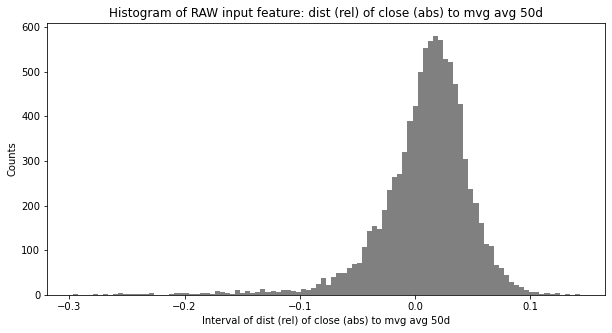

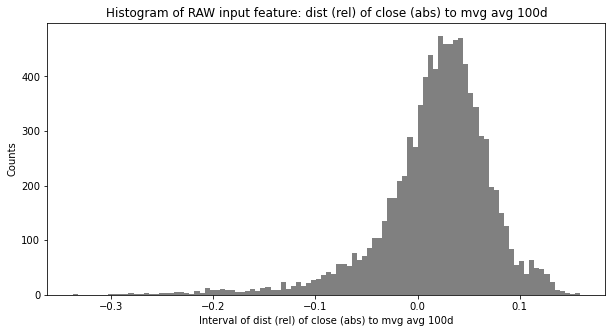

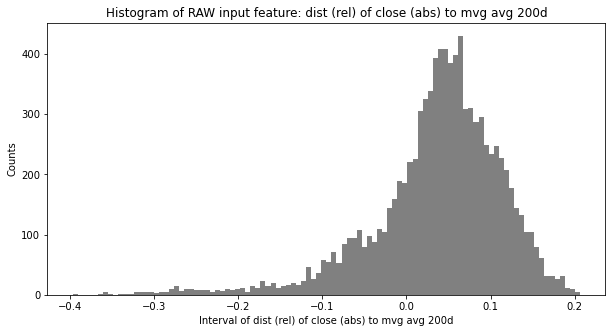

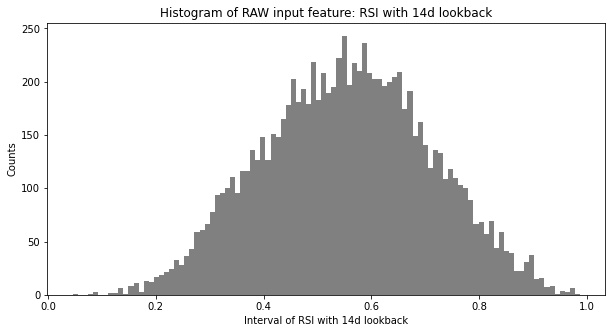

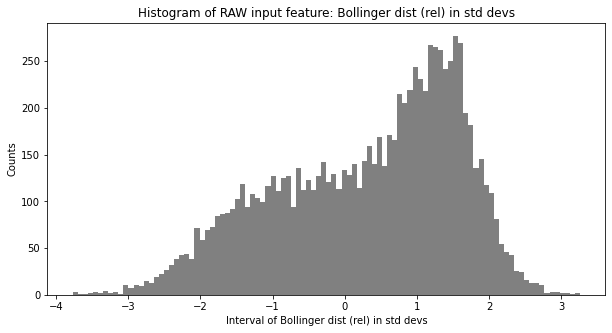

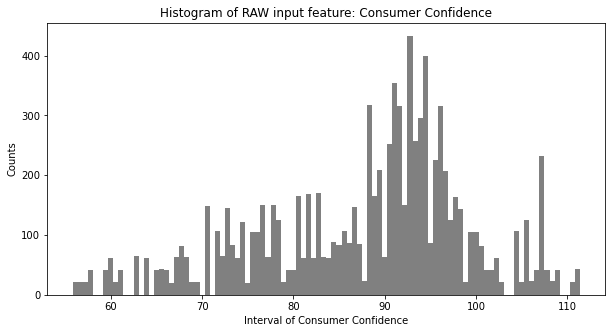

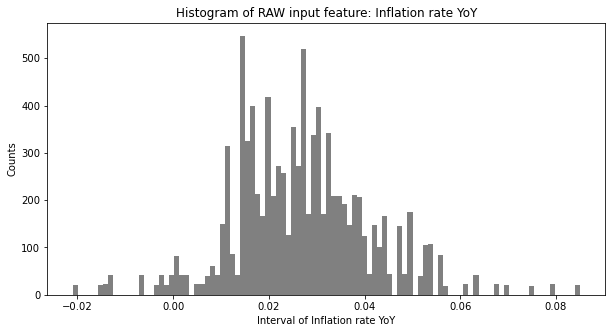

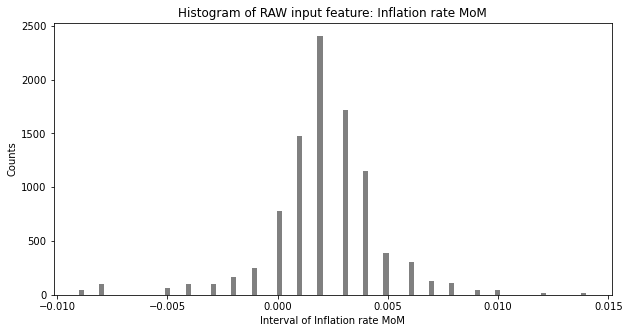

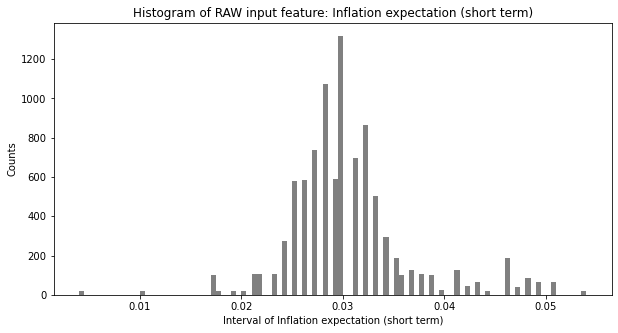

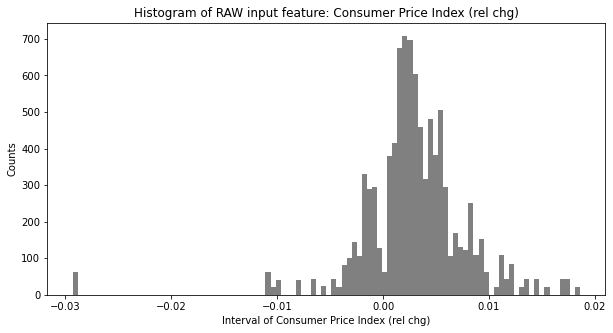

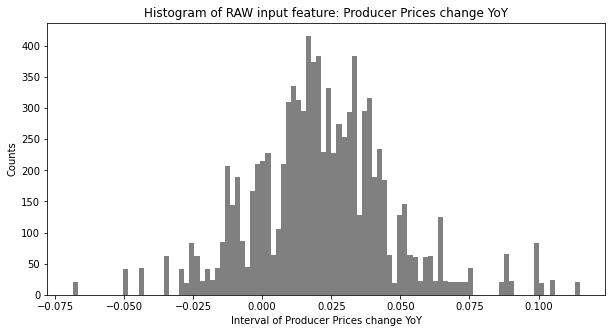

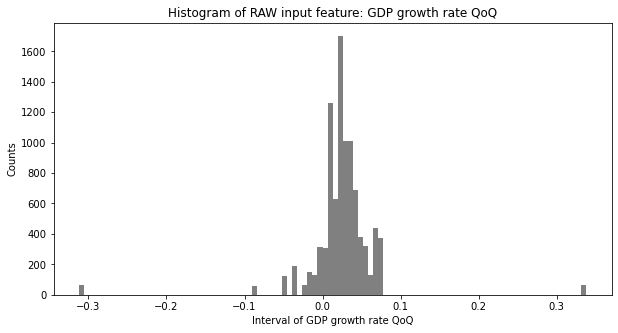

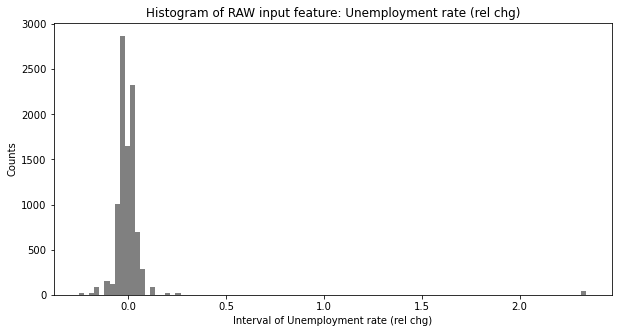

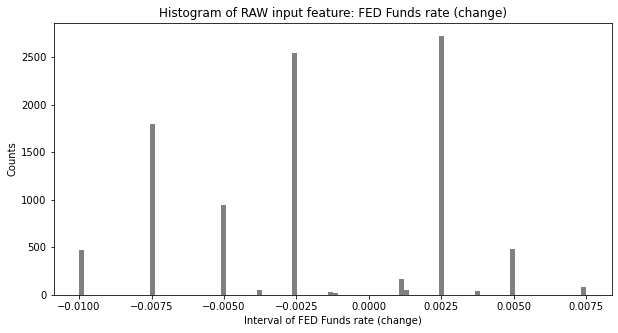

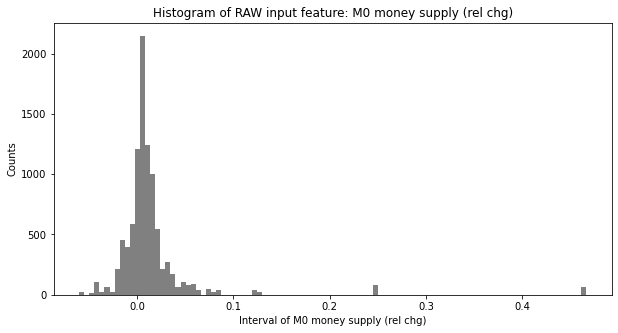

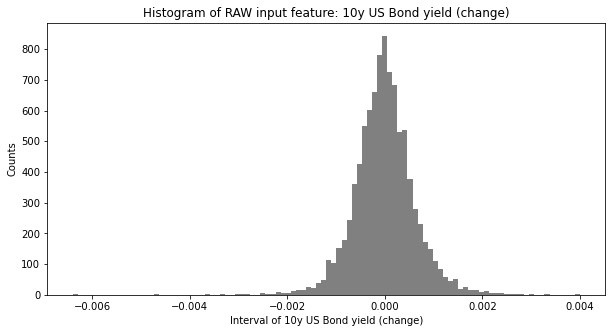

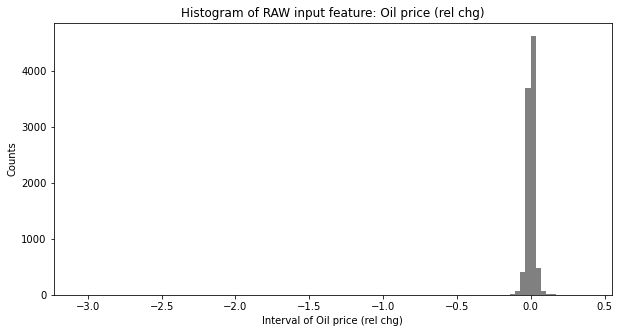

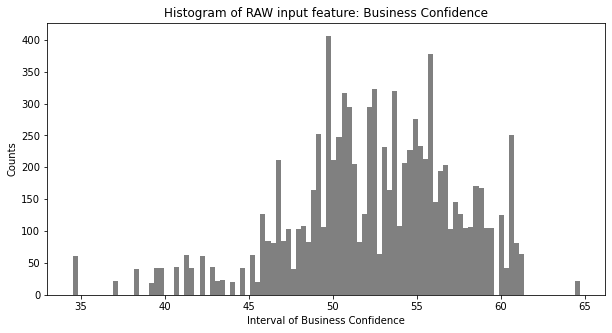

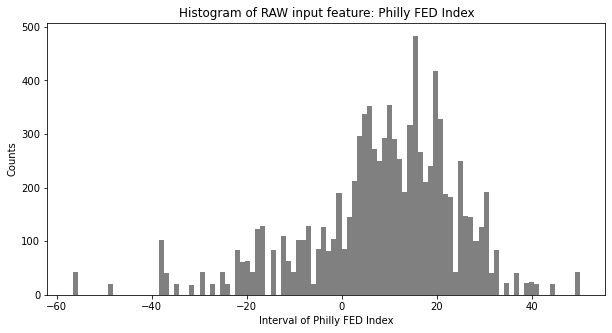

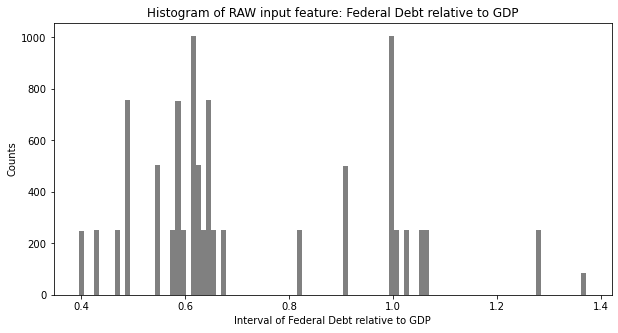

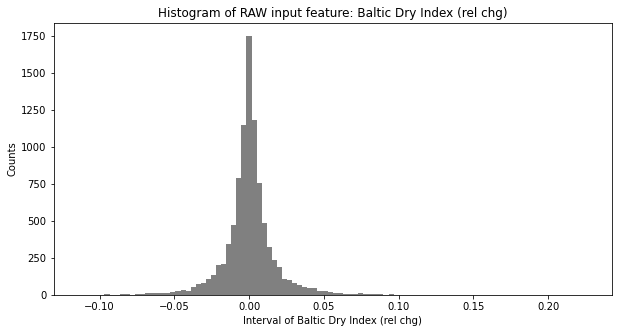

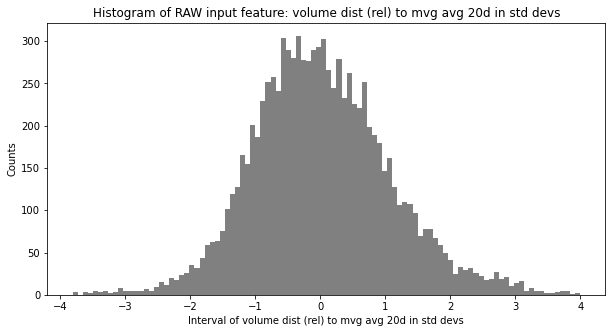

In [6]:
## Visual inspection of distribution for all RAW input features:

# Loop over input features:
for i in range(len(inputs_text)):

    # Plot histogram of predictions for current input feature:
    nBins = 100
    fig, axes = plt.subplots(1, 1, figsize=(10,5))
    axes.hist(inputs[:,i], nBins, color="grey")
    axes.set_xlabel("Interval of " + inputs_text[i])
    axes.set_ylabel("Counts")
    axes.set_title("Histogram of RAW input feature: " + inputs_text[i])
    plt.show()

### Discussion after visual inspection of input features' statistics and distribution

Since we are going to train CNN/fc models, min/max scaling to [0,1] interval for ALL features seems to be appropriate. It's done in a later step, according to statistics only from **train data**, since we pretend to not know statistics and distribution of validation and test data in advance.

### Define function to split data, custom loss and evaluation metrics

In [7]:
# Define function to split time series 'sequence' into 'n_steps'
def split_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # Find the end of this pattern
        end_ix = i + n_steps
        # Check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # Gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)

In [8]:
### Define custom loss function and evaluation metrics:


## Our trading model would imply going "long" if the model predicts an up movement and going "short" else.

# If prediction and target have same sign, we are actually not losing money, which should be reflected as 
# zero loss in the loss function. Whereas using the classical mse loss would assign a positive loss value if
# prediction and target point in the same direction - but deviate.
# In our trading model we only lose money if the prediction was indicating an up movement and the market declines.
# In this case we have a negative target value and we find loss = -target (to have a positive loss value).
# In addition to that we have a second scenario where we lose money: If the model indicated a down movement and
# the market gains, we have a positive target value that equals the loss. Hence loss = target (positive loss value).

# This is encountered in the following customized loss function:
def custom_loss(y_true, y_pred):
    
    # Get sign of targets (y_true)
    eval = K.sign(y_true)
    
    # Need to switch dtype to float32:
    eval = K.cast(eval, dtype='float32')
    
    # Get boolean expression: target != prediction?
    eval = K.not_equal(eval, K.sign(y_pred))
    
    # Convert boolean expression to float32
    eval = K.cast(eval, dtype='float32')
    
    # Multiply with targets (y_true), again need to switch dtype to fload32
    eval = eval * K.cast(K.abs(y_true), dtype='float32')
    
    return eval


# Try instead to adjust the classical mse loss: It shall have non-zero loss only if prediction and target deviate.
# Do this with a mask.
def custom_mse(y_true, y_pred):
    
    # Calculate mse as squared deviation of predictions from targets:
    mse = K.square(y_true - y_pred)
    
    # Need to switch dtype to float32:
    mse = K.cast(mse, dtype='float32')
    
    # Get sign of predictions (y_pred)
    eval1 = K.sign(y_pred)
            
    # Get sign of targets (y_true)
    eval2 = K.sign(y_true)
    
    # Need to switch dtype to float32:
    eval2 = K.cast(eval2, dtype='float32')
    
    # Get boolean expression: target != prediction?
    mask = K.not_equal(eval1, eval2)
    mask = K.cast(mask, dtype='float32')
    
    # Get adjusted mse:
    eval = mask * mse
    
    return eval


# According to our trading model (described above), we can define the gain function for our strategy:
def gain(y_true, y_pred):
    
    eval = K.sign(y_pred) * y_true
    
    return eval


# The outperformance compared to the naive buy-and-hold strategy is given by:
def outperformance(y_true, y_pred):
    
    eval = (K.sign(y_pred) - 1) * y_true
    
    return eval


# And the accuracy is given by:
def accuracy(y_true, y_pred):
    
    # Get sign of targets (y_true)
    eval = K.sign(y_true)
    
    # Need to switch dtype to float32:
    eval = K.cast(eval, dtype='float32')
    
    # Get boolean expression: target == prediction?
    eval = K.equal(eval, K.sign(y_pred))
    
    # Convert boolean expression to float32
    eval = K.cast(eval, dtype='float32')
    
    return eval

### Define functions for CNN/fc model

In [9]:
def set_CNN_fc(CNN_filters, CNN_kernel_sizes, fc_units, fc_hidden_activation, 
           n_epochs, batch_size, learning_rate, loss_function):
    """
    Sets up CNN/fc model. Can be used for multi-run experiments.
    
    Parameters:
    ===========
    CNN_filters: Array of integer numbers to specify the number of feature maps in all CNN layers.
    CNN_kernel_sizes: Array of integer numbers to specify the filter sizes in all CNN layers.
    fc_units: Array of integer numbers to specify the number of units in all hidden fc layers.
    fc_hidden_activation: Activation function for hidden fc layers, 'linear' or 'sigmoid'.
    n_epochs: Integer number to specify the number of epochs for a single run.
    batch_size: Integer number to specify the batch size used for training the model.
    learning_rate: Floating point number to set the learning rate for the optimizer.
    loss_function: String ('mse', 'custom_mse', 'custom_loss') to choose the loss function.
    
    Returns:
    ========
    model
    
    """
    
    # Start model definition:
    model = Sequential()
    
    # Add input layer:
    input_shape = (input_length, len(input_features))
    model.add(Input(shape=input_shape))
    
    # Add CNN layer(s):
    for i in range(len(CNN_filters)):
        model.add(Conv1D(filters=CNN_filters[i], kernel_size=CNN_kernel_sizes[i], strides=1,
                         kernel_initializer=weight_init, bias_initializer = bias_init))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))
        
        # Add max pooling, if input_length is equal or above 40d to limit number of trainable parameters:
        if input_length >= 40:
            model.add(MaxPooling1D(pool_size=2))
    
    # Flatten CNN output:
    model.add(Flatten())
    
    # Add hidden fc layer(s):
    for i in range(len(fc_units)):
        model.add(Dense(units=fc_units[i], activation = fc_hidden_activation,
                        kernel_initializer=weight_init, bias_initializer = bias_init))
    
    # Add output unit:
    model.add(Dense(units=1, name = "output", activation = 'linear',
                    kernel_initializer=weight_init, bias_initializer = bias_init))

    # Compile model with desired loss function:
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function,
                  metrics=([]))
#                  metrics=(['mse', custom_mse, custom_loss, gain, outperformance, accuracy]))
   
    return model

### Pre-process inputs and targets, define model parameters, single-run model

In [10]:
### Set parameters:

## Data pre-processing, pick inputs from:
# 0 - close (rel chg)
# 1 - vol (rel chg)
# 2 - range (rel)
# 3 - dist (rel) of close (abs) to moving average 20d
# 4 - dist (rel) of close (abs) to moving average 50d
# 5 - dist (rel) of close (abs) to moving average 100d
# 6 - dist (rel) of close (abs) to moving average 200d
# 7 - RSI with 14d lookback
# 8 - Bollinger dist (rel) of close (abs) to its moving average 20d - expressed in std devs
# 9 - Consumer Confidenc
# 10 - Inflation rate YoY
# 11 - Inflation rate MoM
# 12 - Inflation expectation (short term)
# 13 - Consumer Price Index (rel chg)
# 14 - Producer Prices change YoY
# 15 - GDP growth rate QoQ
# 16 - Unemployment rate (rel chg)
# 17 - FED Funds rate (change)
# 18 - M0 money supply (rel chg)
# 19 - 10y US Bond yield (change)
# 20 - Oil price (rel chg)
# 21 - Business Confidence
# 22 - Philly FED Index
# 23 - Federal Debt relative to GDP
# 24 - Baltic Dry Index (rel chg)
# 25 - Dist (rel) of volume (abs) to its moving average 20d - expressed in std devs

input_features = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,) # Start with ALL technical features
target_horizons = (0,1,2,3,) # 0: 1d, 1: 5d, 2: 10d, 3: 20d
input_length = 20

# Model parameters:
weight_init = tfi.glorot_uniform() # Taken as default.
bias_init = tfi.Zeros() # Taken as default.
CNN_filters = [10,20]
CNN_kernel_sizes = [5,5]
fc_units = [20,10]
fc_hidden_activation = 'sigmoid'
n_epochs = 10
batch_size = 20
learning_rate = 0.0001
loss_function = 'mse' # ('mse', custom_mse or custom_loss) to choose the loss function.

In [11]:
# Select specified input features:
inputs_selected = inputs[:,input_features]

# Select target horizon:
target_selected = targets[:, target_horizons]

# Split input values into sequences of specified input length:
inputs_split = split_sequence(inputs_selected, input_length)

# Adjust data, year and targets: Cut first (input_length - 1) entries
data_cut = data[input_length-1:]
year_cut = year[input_length-1:]
target_cut = target_selected[input_length-1:]

In [12]:
## Split inputs and targets into train / validation / test sets, according to year:

# Train data: 1990 .. 2009
# Val data:   2010 .. 2019
# Test data:  2020 .. end

train_input = inputs_split[year_cut <= 2009]
val_input = inputs_split[(year_cut >= 2010) & (year_cut < 2020)]
test_input = inputs_split[year_cut >= 2020]

train_target = target_cut[year_cut <= 2009]
val_target = target_cut[(year_cut >= 2010) & (year_cut < 2020)]
test_target = target_cut[year_cut >= 2020]

# Convert to binary targets (up = 1, down = 0):
train_target_bin = (train_target>0).astype(int)
val_target_bin = (val_target>0).astype(int)
test_target_bin = (test_target>0).astype(int)

# Check dimensions:
print("train_input shape (samples, time steps, features): ", train_input.shape)
print("val_input shape (samples, time steps, features): ", val_input.shape)
print("test_input shape (samples, time steps, features): ", test_input.shape)
print("\ntrain_target shape (samples, features): ", train_target.shape)
print("val_target shape (samples, features): ", val_target.shape)
print("test_target shape (samples, features): ", test_target.shape)
print("\ntrain_target_bin shape (samples, features): ", train_target_bin.shape)
print("val_target shape_bin (samples, features): ", val_target_bin.shape)
print("test_target shape_bin (samples, features): ", test_target_bin.shape)

train_input shape (samples, time steps, features):  (6284, 20, 26)
val_input shape (samples, time steps, features):  (2516, 20, 26)
test_input shape (samples, time steps, features):  (587, 20, 26)

train_target shape (samples, features):  (6284, 4)
val_target shape (samples, features):  (2516, 4)
test_target shape (samples, features):  (587, 4)

train_target_bin shape (samples, features):  (6284, 4)
val_target shape_bin (samples, features):  (2516, 4)
test_target shape_bin (samples, features):  (587, 4)


In [13]:
# Get min and max for ALL input features from TRAIN data:
train_min = np.min(train_input, axis=(0,1))
train_max = np.max(train_input, axis=(0,1))

# Apply min max scaling to train / val / test inputs: Substract min and divide by (max - min)
train_input_scaled = (train_input - train_min) / (train_max - train_min)
val_input_scaled = (val_input - train_min) / (train_max - train_min)
test_input_scaled = (test_input - train_min) / (train_max - train_min)

# Check result:
print("train_input MIN: ", np.round(np.min(train_input_scaled, axis=(0,1)), 2))
print("train_input MAX: ", np.round(np.max(train_input_scaled, axis=(0,1)), 2))
print("\nval_input MIN: ", np.round(np.min(val_input_scaled, axis=(0,1)), 2))
print("val_input MAX: ", np.round(np.max(val_input_scaled, axis=(0,1)), 2))
print("\ntest_input MIN: ", np.round(np.min(test_input_scaled, axis=(0,1)), 2))
print("test_input MAX: ", np.round(np.max(test_input_scaled, axis=(0,1)), 2))

train_input MIN:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
train_input MAX:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]

val_input MIN:  [ 0.43  0.01 -0.    0.38  0.36  0.37  0.42  0.04 -0.   -0.01  0.23  0.26
  0.38  0.38  0.33  0.44  0.04  0.   -0.01  0.38  0.45  0.5   0.32  0.66
 -0.    0.03]
val_input MAX:  [0.79 0.15 0.35 0.9  0.87 0.88 0.93 1.01 0.97 0.81 0.71 0.65 0.89 0.85
 0.76 0.86 0.42 0.67 0.32 0.84 0.94 0.99 0.98 1.57 1.04 1.02]

test_input MIN:  [ 0.26  0.01  0.    0.19  0.05  0.11  0.22  0.08  0.08  0.05  0.29  0.04
  0.36  0.47  0.32 -1.42 -0.6  -0.17 -0.04  0.4  -5.37  0.27 -0.09  1.54
  0.03  0.18]
test_input MAX:  [0.93 0.08 0.31 1.   0.97 0.97 0.94 0.94 0.91 0.79 1.26 0.91 1.06 0.97
 1.1  2.64 8.76 0.67 0.57 0.87 1.39 1.14 1.1  2.29 1.31 1.02]


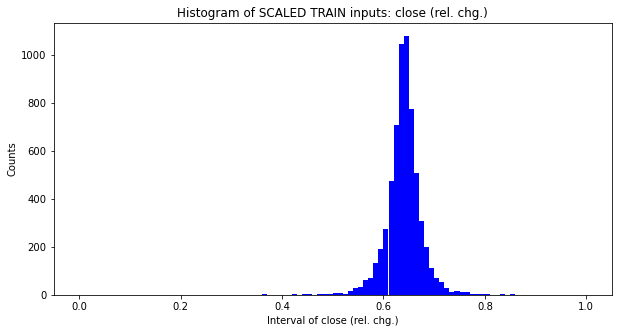

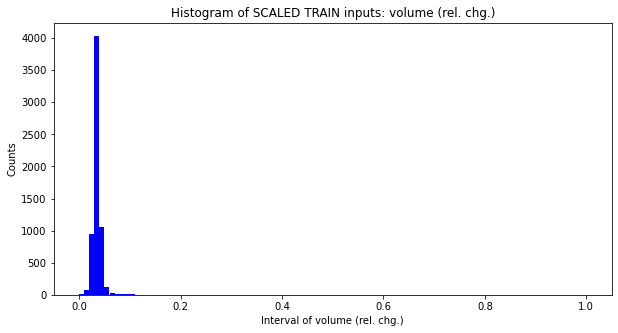

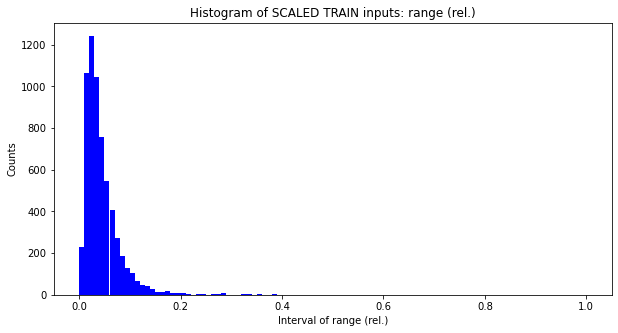

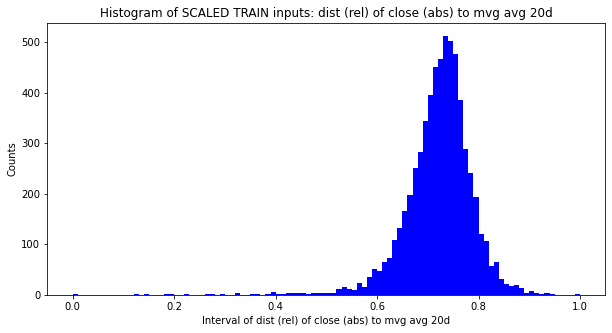

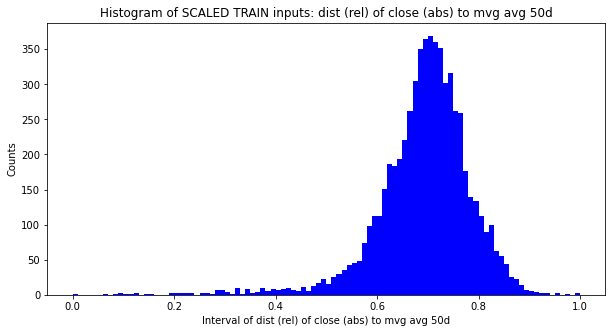

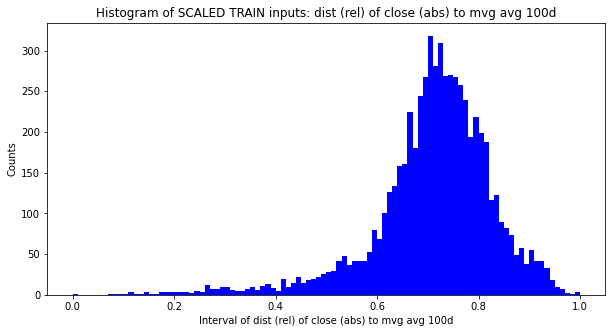

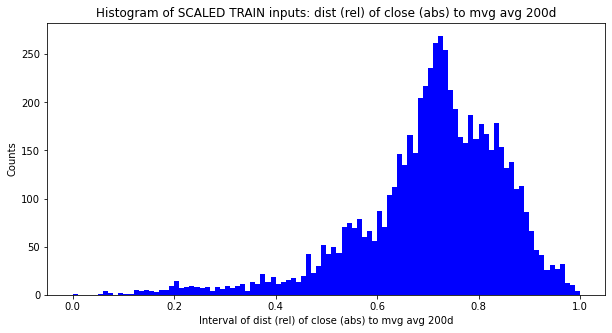

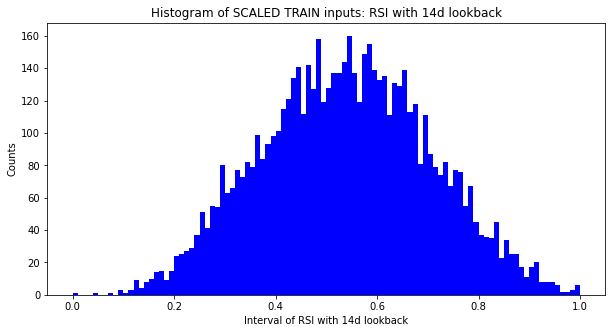

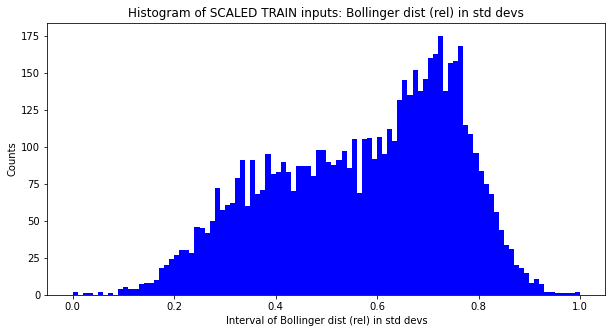

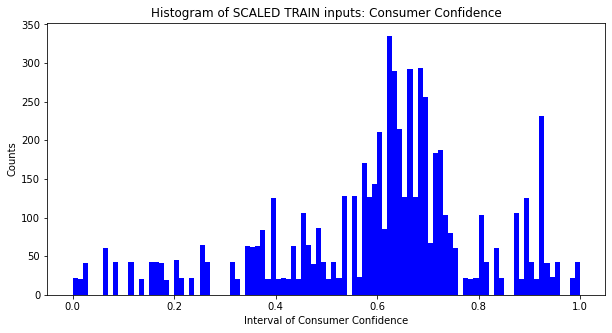

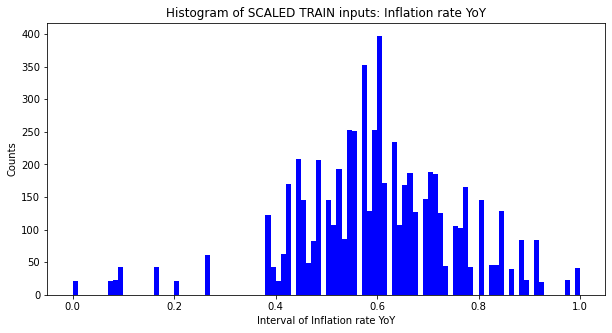

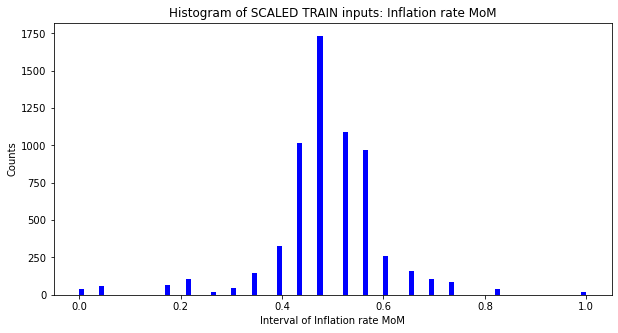

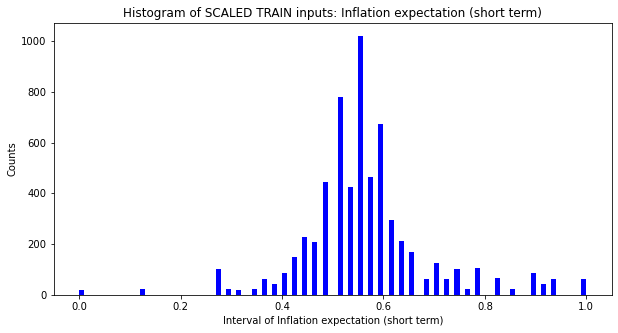

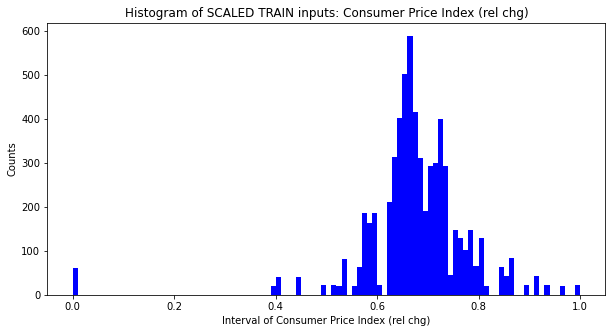

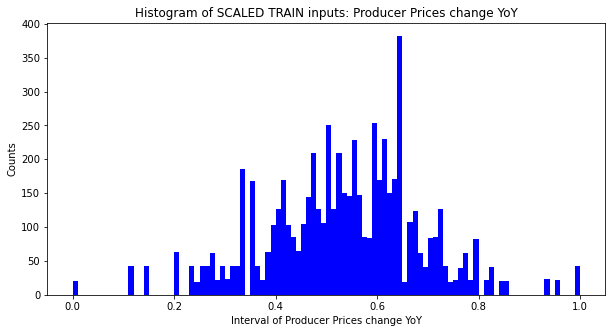

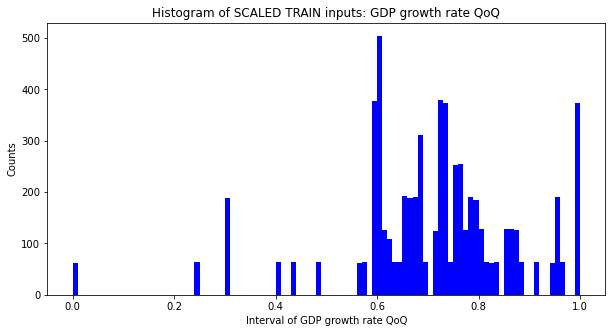

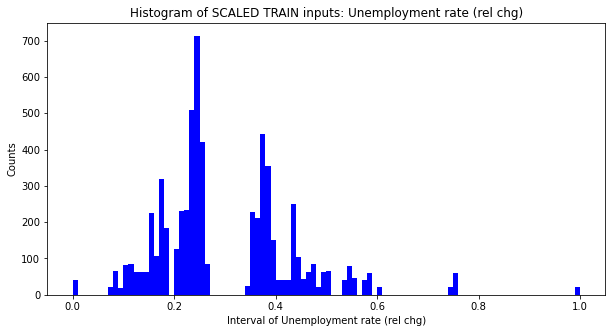

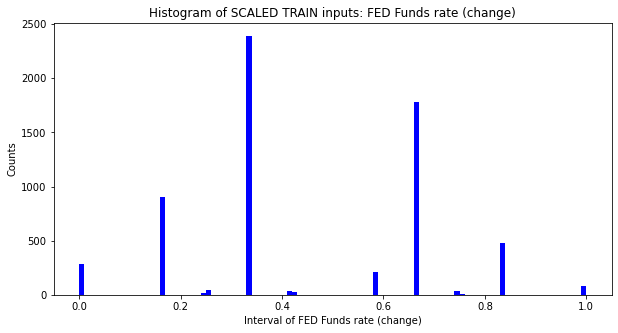

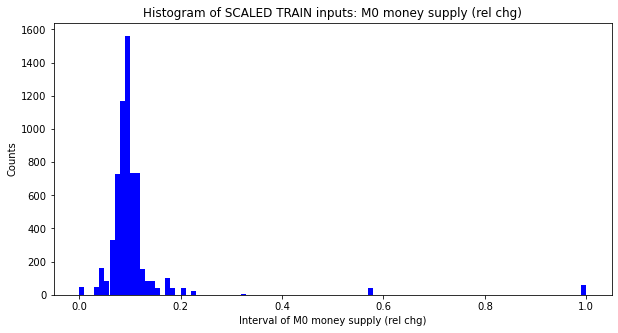

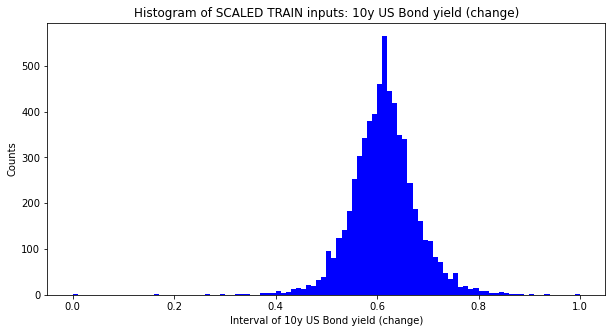

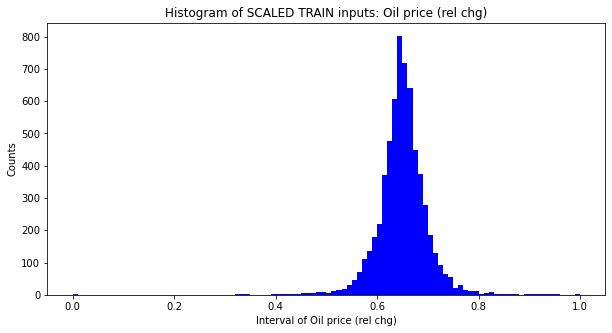

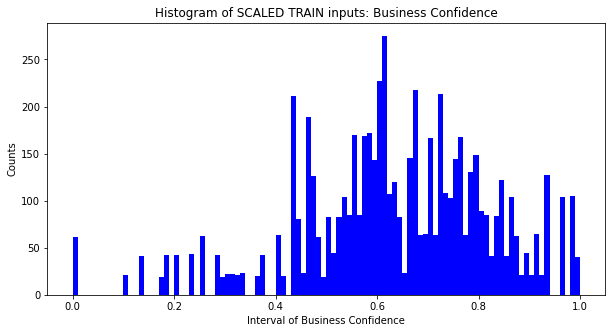

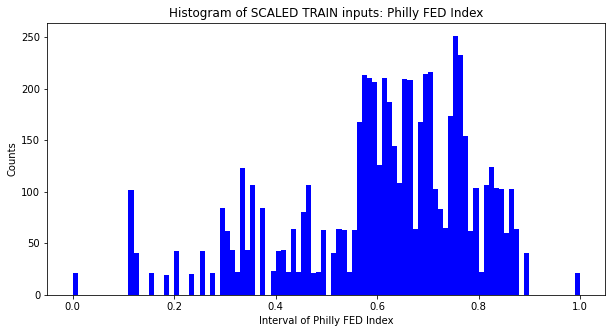

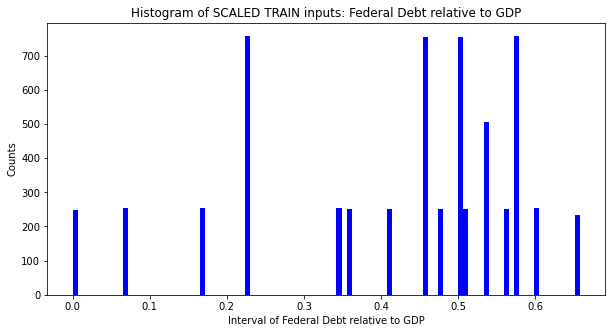

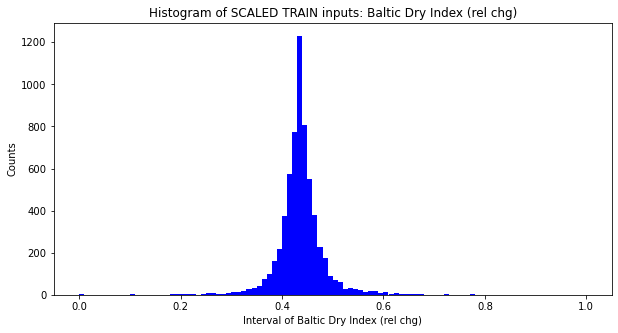

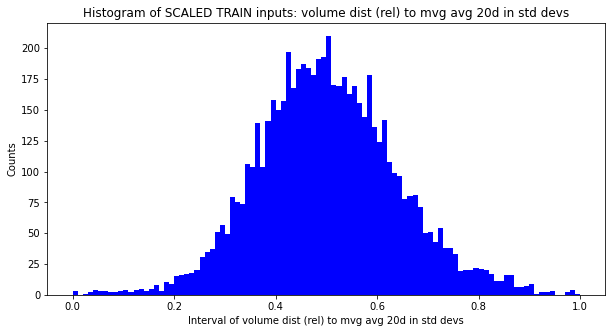

In [14]:
## Visual inspection of distribution for all SCALED TRAIN inputs:

# Loop over input features:
for i in range(len(inputs_text)):

    # Plot histogram of distribution for current input feature:
    nBins = 100
    fig, axes = plt.subplots(1, 1, figsize=(10,5))
    axes.hist(train_input_scaled[:,0,i], nBins, color="blue")
    axes.set_xlabel("Interval of " + inputs_text[i])
    axes.set_ylabel("Counts")
    axes.set_title("Histogram of SCALED TRAIN inputs: " + inputs_text[i])
    plt.show()

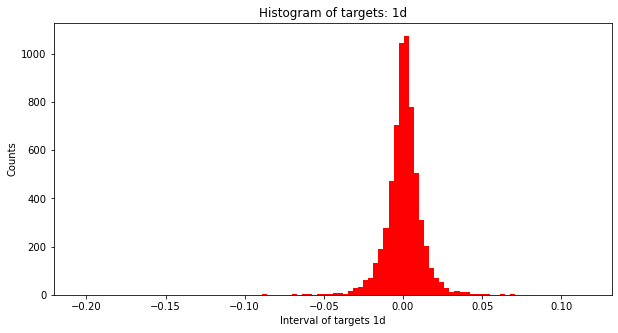

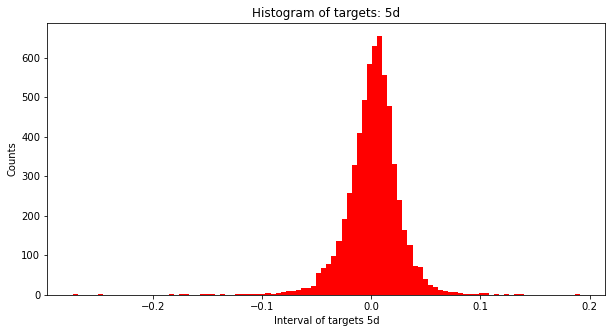

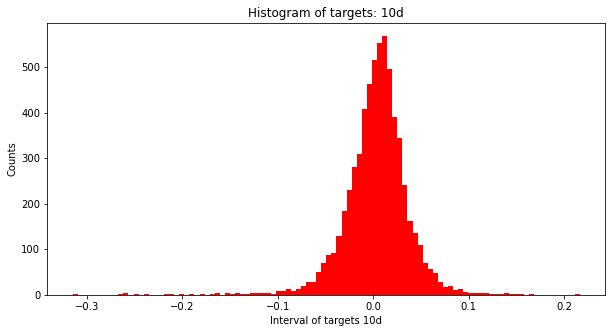

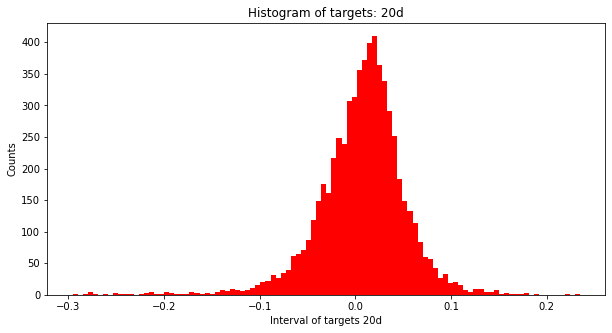

In [15]:
## Visual inspection of distribution for ALL target horizons (targets UNSCALED!):

# Loop over target horizons:
for i in range(len(targets_text)):

    # Plot histogram of distribution for current target horizon:
    nBins = 100
    fig, axes = plt.subplots(1, 1, figsize=(10,5))
    axes.hist(train_target[:,i], nBins, color="red")
    axes.set_xlabel("Interval of targets " + targets_text[i])
    axes.set_ylabel("Counts")
    axes.set_title("Histogram of targets: " + targets_text[i])
    plt.show()

### Single-run with CNN/fc modele on single target horizon

In [24]:
# Set up compiled CNN/fc model:
model = set_CNN_fc(CNN_filters, CNN_kernel_sizes, fc_units, fc_hidden_activation,
                   n_epochs, batch_size, learning_rate, loss_function)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 16, 10)            1310      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 10)            40        
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 10)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 12, 20)            1020      
_________________________________________________________________
batch_normalization_5 (Batch (None, 12, 20)            80        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 12, 20)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 240)              

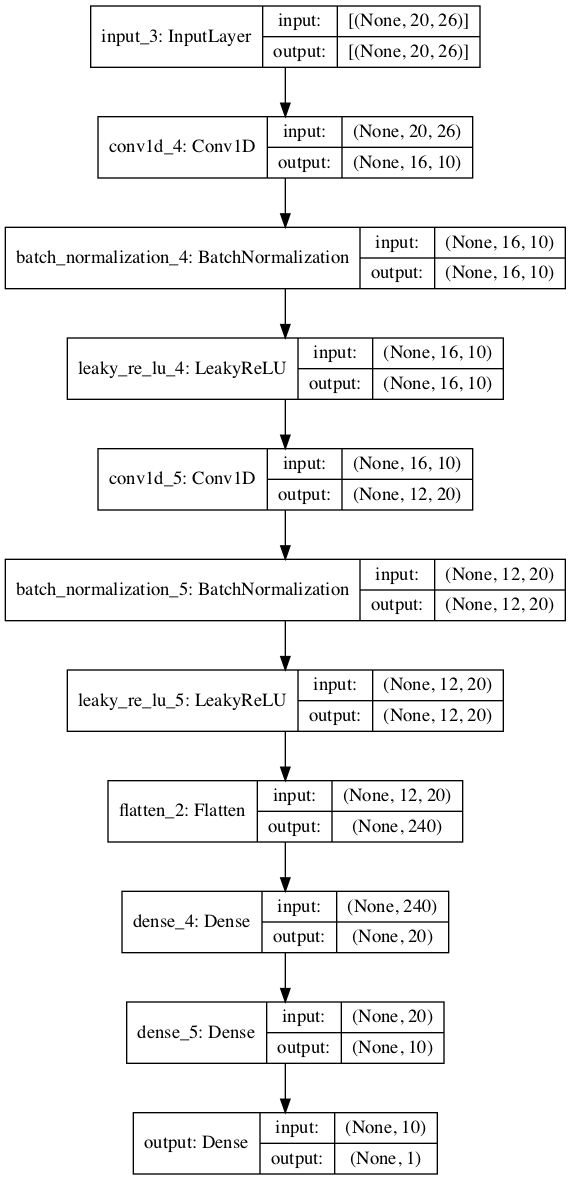

In [25]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [26]:
# Choose single target horizon:
target_horizon = (3,) # 0: 1d, 1: 5d, 2: 10d, 3: 20d

In [27]:
# Train model on scaled inputs and un-scaled targets:
history = model.fit(train_input_scaled, train_target[:,target_horizon], epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=2, validation_data=(val_input_scaled, val_target[:,target_horizon]))

Epoch 1/10
315/315 - 1s - loss: 0.1804 - val_loss: 0.0097
Epoch 2/10
315/315 - 0s - loss: 0.0064 - val_loss: 0.0137
Epoch 3/10
315/315 - 0s - loss: 0.0040 - val_loss: 0.0135
Epoch 4/10
315/315 - 1s - loss: 0.0035 - val_loss: 0.0125
Epoch 5/10
315/315 - 1s - loss: 0.0031 - val_loss: 0.0123
Epoch 6/10
315/315 - 0s - loss: 0.0029 - val_loss: 0.0099
Epoch 7/10
315/315 - 0s - loss: 0.0027 - val_loss: 0.0114
Epoch 8/10
315/315 - 0s - loss: 0.0026 - val_loss: 0.0124
Epoch 9/10
315/315 - 0s - loss: 0.0024 - val_loss: 0.0103
Epoch 10/10
315/315 - 0s - loss: 0.0023 - val_loss: 0.0102


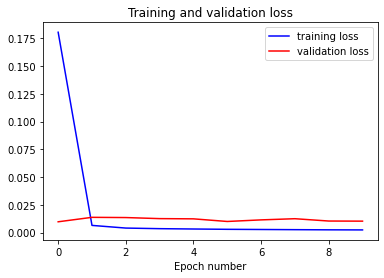

In [28]:
# Plot train and val_loss (mse)
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation loss')
plt.legend()
plt.show() 

In [29]:
# Get model predictions:
train_pred = model.predict(train_input_scaled)
val_pred = model.predict(val_input_scaled)
test_pred = model.predict(test_input_scaled)

# Convert to binary prediction UP (1) / DOWN (0):
train_pred_bin = (train_pred>0).astype(int)
val_pred_bin = (val_pred>0).astype(int)
test_pred_bin = (test_pred>0).astype(int)

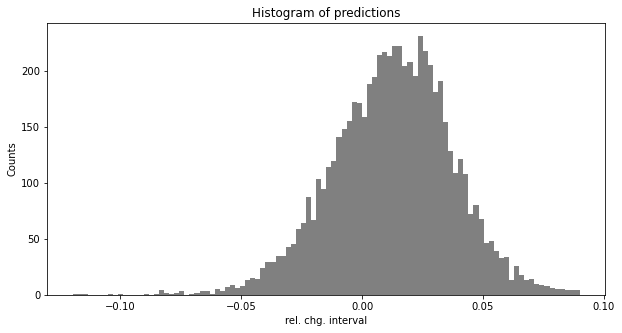

In [30]:
# Plot histogram of predictions
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_pred[:,0], nBins, color="grey")
axes.set_xlabel("rel. chg. interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of predictions")
plt.show()

In [31]:
# Get binary prediction accuracy - in terms of correctly predicted up/down movements:
train_acc = np.sum(train_pred_bin == train_target_bin[:,target_horizon]) / len(train_pred_bin)
val_acc = np.sum(val_pred_bin == val_target_bin[:,target_horizon]) / len(val_pred_bin)
test_acc = np.sum(test_pred_bin == test_target_bin[:,target_horizon]) / len(test_pred_bin)

# Get "naive" accuracy, when we always predict an UP movement.
# In other words this reflects the relative amount of UP movements.
train_acc_naiv = np.sum(train_target_bin[:,target_horizon] / len(train_target))
val_acc_naiv = np.sum(val_target_bin[:,target_horizon] / len(val_target))
test_acc_naiv = np.sum(test_target_bin[:,target_horizon] / len(test_target))

print("train acc (%): ", np.round(train_acc * 100,1), "%")
print("val acc (%): ", np.round(val_acc * 100,1), "%")
print("test acc (%)", np.round(test_acc * 100,1), "%")
print("\nnaive train acc (%)", np.round(train_acc_naiv * 100,1), "%")
print("naive val acc (%)", np.round(val_acc_naiv * 100,1), "%")
print("naive test acc (%)", np.round(test_acc_naiv * 100,1), "%")

train acc (%):  63.8 %
val acc (%):  62.0 %
test acc (%) 56.0 %

naive train acc (%) 61.7 %
naive val acc (%) 67.2 %
naive test acc (%) 68.3 %


### Discussion: Single-run CNN/fc model

The model trains well, find predictions somewhat centered arround *zero*, as the histogram of targets shows. But the accuracy is poor - compared to naive accuracy. Although we find train accuracy to exceed naive accuracy! But overall, our model is not better than just **random guessing**, if trained on **ALL technical plus external features** as *combined* input features in *single-run* mode.

This holds true for **all target horizons**, where target horizons need to be set manually. 

### Multi-run experiment with CNN/fc model on ALL technical plus external features and ALL targets

In [32]:
## Look at heuristics to set benchmark:

# Get "naive" accuracy, when we always predict an UP movement.
# In other words this reflects the relative amount of UP movements.
train_acc_naiv = np.sum(train_target_bin, axis=0) / len(train_target)
val_acc_naiv = np.sum(val_target_bin, axis=0) / len(val_target)
test_acc_naiv = np.sum(test_target_bin, axis=0) / len(test_target)

# Stack naive accuracies:
accuracy_naiv = np.stack([train_acc_naiv, val_acc_naiv, test_acc_naiv])

print("naive acc (%) for target [1d  5d  10d  20d]")
print("===========================================")
print("naive train acc (%)", np.round(train_acc_naiv * 100,1), "%")
print("naive val acc (%)", np.round(val_acc_naiv * 100,1), "%")
print("naive test acc (%)", np.round(test_acc_naiv * 100,1), "%")

naive acc (%) for target [1d  5d  10d  20d]
naive train acc (%) [53.5 56.7 58.5 61.7] %
naive val acc (%) [54.8 60.7 63.9 67.2] %
naive test acc (%) [55.  60.1 63.9 68.3] %


In [34]:
# Specify number of runs for each target horizon:
n_runs = 10

# Initialize storage for train/val/test accuracies for ALL target horizons and ALL runs.
# Need dimensions (3, #horizons, #runs):
accuracy_all_CNNfc_TechExt = np.zeros((3,len(target_horizons),n_runs))

## Loop over target horizons:
for num_horizon in range(len(target_horizons)):
    
    # Get current target_horizon:
    target_horizon = target_horizons[num_horizon]
    
    # Print status:
    print("Target horizon: ", targets_text[num_horizon], ", ", num_horizon+1, " of ", len(target_horizons))
    
    ## Loop over number of runs:
    for run in range(n_runs):
        
        # Print status:
        print("  run: ", run+1, " of ", n_runs)
        
        # Set up compiled CNN/fc model:
        model = set_CNN_fc(CNN_filters, CNN_kernel_sizes, fc_units, fc_hidden_activation,
                           n_epochs, batch_size, learning_rate, loss_function)

        # Train model on scaled inputs and un-scaled targets:
        history = model.fit(train_input_scaled, train_target[:,target_horizon], epochs=n_epochs, batch_size=batch_size,
                            shuffle=True, verbose=0, validation_data=(val_input_scaled, val_target[:,target_horizon]))

        # Get model predictions:
        train_pred = model.predict(train_input_scaled)
        val_pred = model.predict(val_input_scaled)
        test_pred = model.predict(test_input_scaled)

        # Convert to binary prediction UP (1) / DOWN (0):
        train_pred_bin = (train_pred>0).astype(int)
        val_pred_bin = (val_pred>0).astype(int)
        test_pred_bin = (test_pred>0).astype(int)

        # Get binary prediction accuracy - in terms of correctly predicted up/down movements:
        train_acc = np.sum(train_pred_bin == np.reshape(train_target_bin[:,target_horizon], (len(train_target_bin),1))) / len(train_pred_bin)
        val_acc = np.sum(val_pred_bin == np.reshape(val_target_bin[:,target_horizon], (len(val_target_bin),1))) / len(val_pred_bin)
        test_acc = np.sum(test_pred_bin == np.reshape(test_target_bin[:,target_horizon], (len(test_target_bin),1))) / len(test_pred_bin)
                
        # Store accuracies for current run:
        accuracy_all_CNNfc_TechExt[0,num_horizon,run] = train_acc
        accuracy_all_CNNfc_TechExt[1,num_horizon,run] = val_acc
        accuracy_all_CNNfc_TechExt[2,num_horizon,run] = test_acc

Target horizon:  1d ,  1  of  4
  run:  1  of  10
  run:  2  of  10
  run:  3  of  10
  run:  4  of  10
  run:  5  of  10
  run:  6  of  10
  run:  7  of  10
  run:  8  of  10
  run:  9  of  10
  run:  10  of  10
Target horizon:  5d ,  2  of  4
  run:  1  of  10
  run:  2  of  10
  run:  3  of  10
  run:  4  of  10
  run:  5  of  10
  run:  6  of  10
  run:  7  of  10
  run:  8  of  10
  run:  9  of  10
  run:  10  of  10
Target horizon:  10d ,  3  of  4
  run:  1  of  10
  run:  2  of  10
  run:  3  of  10
  run:  4  of  10
  run:  5  of  10
  run:  6  of  10
  run:  7  of  10
  run:  8  of  10
  run:  9  of  10
  run:  10  of  10
Target horizon:  20d ,  4  of  4
  run:  1  of  10
  run:  2  of  10
  run:  3  of  10
  run:  4  of  10
  run:  5  of  10
  run:  6  of  10
  run:  7  of  10
  run:  8  of  10
  run:  9  of  10
  run:  10  of  10


In [35]:
# Post-processing of accuracies from multi-run experiments on ALL target horizons:
# Mean, min, max over n_runs.
accuracy_mean_CNNfc_TechExt = np.mean(accuracy_all_CNNfc_TechExt, axis=-1)
accuracy_min_CNNfc_TechExt = np.min(accuracy_all_CNNfc_TechExt, axis=-1)
accuracy_max_CNNfc_TechExt = np.max(accuracy_all_CNNfc_TechExt, axis=-1)

In [36]:
accuracy_mean_CNNfc_TechExt

array([[0.5100732 , 0.5559198 , 0.57612985, 0.61798218],
       [0.49848967, 0.50210652, 0.52611288, 0.59960254],
       [0.49795571, 0.50954003, 0.50647359, 0.58211244]])

In [37]:
accuracy_min_CNNfc_TechExt

array([[0.48663272, 0.49904519, 0.51464036, 0.51241248],
       [0.45111288, 0.39308426, 0.36486486, 0.45508744],
       [0.44633731, 0.39522998, 0.37649063, 0.42589438]])

In [38]:
accuracy_max_CNNfc_TechExt

array([[0.53325907, 0.58036283, 0.61266709, 0.67091025],
       [0.54610493, 0.60651828, 0.64030207, 0.67209857],
       [0.54684838, 0.60477002, 0.63543441, 0.6746167 ]])

In [114]:
print("naive acc (%) for target [1d  5d  10d  20d]")
print("===========================================")
print("naive train acc (%)", np.round(train_acc_naiv * 100,1), "%")
print("naive val acc (%)", np.round(val_acc_naiv * 100,1), "%")
print("naive test acc (%)", np.round(test_acc_naiv * 100,1), "%")

naive acc (%) for target [1d  5d  10d  20d]
naive train acc (%) [53.5 56.7 58.5 61.7] %
naive val acc (%) [54.8 60.7 63.9 67.2] %
naive test acc (%) [55.  60.1 63.9 68.3] %


### Discussion on multi-run experiment with CNN/fc on ALL technical features plus external features

Results are significantly better than with just technical features!

Including external features indeed helps to improve accuracy, to answer **Q2**.

The maximum accuracy from **10 runs** is found to exceed naive accuracies sometimes, but not always.

--> Still we do not consistently beat the naive buy-and-hold strategy with our CNN/fc model.